Face Verification with a Siamese Network

In [ ]:
%pip install tensorflow==2.4.1 opencv-python matplotlib

In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer , Conv2D , Dense , MaxPooling2D , Input , Flatten
import tensorflow as tf

In [3]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

Collecting Positive , Negative and Anchors

In [7]:
#Move LFW Images to the data/negative directory 

for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [4]:
import uuid

In [5]:
uuid.uuid1()

UUID('1f07124e-15bd-11f0-bd8c-485f99bcb960')

In [ ]:
# Establish a coneection to a webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    frame = frame[70:70+250,270:270+250, :]


    if cv2.waitKey(1) & 0xFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    if cv2.waitKey(1) & 0xFF == ord('o'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)



    cv2.imshow('Kill your self already', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

Get Image Directories

In [6]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [7]:
Test_Dir = anchor.as_numpy_iterator()

In [14]:
Test_Dir.next()

b'data\\anchor\\d12be3a9-1222-11f0-9502-485f99bcb95f.jpg'

In [ ]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0 # Devide every pixel by 255 to ensure it only has a value between 0 and 1
    return img

In [ ]:
preprocess('data\\anchor\\d12be3a9-1222-11f0-9502-485f99bcb95f.jpg')

Create Labelled Dataset

In [ ]:
tf.ones(len(anchor))

In [27]:
# (anchor, positive) => 1,1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0,0

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [28]:
example = data.as_numpy_iterator()

In [29]:
example.next()

(b'data\\anchor\\c977d278-1221-11f0-9a10-485f99bcb95f.jpg',
 b'data\\positive\\0548a600-1222-11f0-a43c-485f99bcb95f.jpg',
 1.0)

In [42]:
Test = example.next()

In [43]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [56]:
preprocess_twin(*Test)

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.18014705, 0.20269608, 0.20490196],
         [0.16887255, 0.18259804, 0.12696078],
         [0.1487745 , 0.15661764, 0.10980392],
         ...,
         [0.15367647, 0.13161765, 0.05833333],
         [0.18995099, 0.15906863, 0.08578432],
         [0.20122549, 0.17524509, 0.1       ]],
 
        [[0.16789216, 0.18872549, 0.21102941],
         [0.15759803, 0.17524509, 0.14583333],
         [0.14338236, 0.15      , 0.1264706 ],
         ...,
         [0.14607844, 0.1367647 , 0.05955882],
         [0.17524509, 0.15857843, 0.07916667],
         [0.1889706 , 0.18161765, 0.09705883]],
 
        [[0.18848039, 0.22034314, 0.23259804],
         [0.15833333, 0.1870098 , 0.13970588],
         [0.12818627, 0.14215687, 0.1002451 ],
         ...,
         [0.1375    , 0.14240196, 0.05784314],
         [0.15980393, 0.15490197, 0.07254902],
         [0.18308823, 0.18308823, 0.08897059]],
 
        ...,
 
        [[0.55245095, 0.5622549 

Build dataloader pipeline

In [57]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [58]:
samples = data.as_numpy_iterator()

In [59]:
samples.next()

(array([[[0.19436274, 0.21568628, 0.19338235],
         [0.18553922, 0.18995099, 0.15784314],
         [0.12720588, 0.12720588, 0.08210784],
         ...,
         [0.13088235, 0.12916666, 0.02745098],
         [0.225     , 0.2122549 , 0.10539216],
         [0.18921569, 0.17352942, 0.06421569]],
 
        [[0.20196079, 0.20343137, 0.19534314],
         [0.18161765, 0.1742647 , 0.15269607],
         [0.17230392, 0.15514706, 0.12058824],
         ...,
         [0.14607844, 0.15171568, 0.05980392],
         [0.17671569, 0.16911764, 0.08088236],
         [0.2002451 , 0.18382353, 0.08651961]],
 
        [[0.18970588, 0.18970588, 0.18382353],
         [0.20367648, 0.18995099, 0.17132352],
         [0.14362745, 0.11813726, 0.08872549],
         ...,
         [0.13382353, 0.13651961, 0.0632353 ],
         [0.1622549 , 0.15318628, 0.0759804 ],
         [0.18848039, 0.1754902 , 0.09803922]],
 
        ...,
 
        [[0.48039216, 0.49019608, 0.4617647 ],
         [0.04068628, 0.04901961, 0.01985

In [60]:
samp = samples.next()

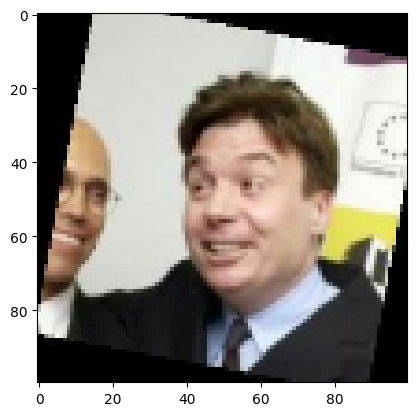

In [63]:
plt.imshow(samp[1])

In [64]:
samp[2]

0.0

In [65]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [66]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

Build Embedding Layer

In [67]:
def Make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    #First Block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    #Second Block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    #Third Block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    #Final Block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='Embedding')

In [68]:
embedding = Make_embedding()

In [69]:
embedding.summary()

Model: "Embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

Build Distance Layer

In [70]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [71]:
def make_siamese_model():

    # Input handler 
    input_image = Input(name='input_image', shape=(100,100,3))
    validation_image = Input(name='validation_image', shape=(100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification
    classifier = Dense(1 , activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='Siamese Network')

In [72]:
Siamese_Model = make_siamese_model()

In [73]:
Siamese_Model.summary()

Model: "Siamese Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_image (InputLayer)   [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
Embedding (Functional)          (None, 4096)         38960448    input_image[0][0]                
                                                                 validation_image[0][0]           
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           Embedding[0][0]    